In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stan
import arviz as az
import nest_asyncio
nest_asyncio.apply()
import pandas as pd

In [35]:
df = pd.read_csv('sample_response_times.csv', delimiter=';')
df.head()

,rt,choice,condition
0,0.477,1.0,1.0
1,0.600,1.0,1.0
2,0.500,0.0,1.0
3,0.416,1.0,1.0
4,0.435,1.0,1.0


/root/anaconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/anaconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


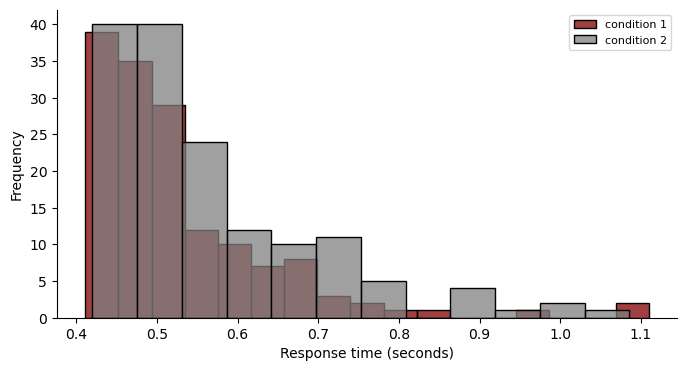

In [40]:
rt1 = df[df.condition == 1]
rt2 = df[df.condition == 2]


rt1v = rt1.rt.values
rt2v = rt2.rt.values

f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(rt1v, color='maroon', ax=ax, label="condition 1")
sns.histplot(rt2v, color="grey", ax=ax, label="condition 2")
sns.despine(ax=ax)
ax.set_xlabel('Response time (seconds)')
ax.set_ylabel('Frequency')
ax.legend(fontsize=8)


In [28]:
program_code="""
data {
    int<lower=1> N;
    array[N] real<lower=0> y;
    array[N] int<lower=1, upper=2> condition;
    array[N] int<lower=0, upper=1> choice;
}

parameters {
    // Your code here
    real<lower=0> v;
    real<lower=0> a;
    real<lower=0, upper=1> b;
    real<lower=0> t;

    real<lower=0> v2;
    real<lower=0> a2;
    real<lower=0, upper=1> b2;
    real<lower=0> t2;
}

model {
    // Priors
    // Your code here
    v ~ gamma(3, 1);
    a ~ gamma(3, 1);
    b ~ beta(2, 2);
    t ~ gamma(2, 1);

    v2 ~ gamma(3, 1);
    a2 ~ gamma(3, 1);
    b2 ~ beta(2, 2);
    t2 ~ gamma(2, 1);

    // Likelihood
    for (n in 1:N) {
        // Condition 1
        if (condition[n] == 1) {
            if (choice[n] == 1) {
                 // Your code here
                y[n] ~ wiener(a, t, b, v);
            }
            else {
                 // Your code here
                y[n] ~ wiener(a, t, 1-b, -v);
            }
        }
        // Condition 2
        if (condition[n] == 2) {
            if (choice[n] == 1) {
                // Your code here
                y[n] ~ wiener(a2, t2, b2, v2);
            }
            else {
                 // Your code here
                y[n] ~ wiener(a2, t2, 1-b2, -v2);
            }
        }
    }
}
"""

In [29]:
# Prepare data in Stan friendly format
data_dict = {
    'y': df.rt.values, 
    'choice': df.choice.values.astype(int),
    'condition': df.condition.values.astype(int),
    'N': df.rt.shape[0]
}

# Compile model
model = stan.build(program_code, data=data_dict)

Building...


Building: 43.3s, done.

In [30]:
# Posterior inference using MCMC
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   1% (203/14000)
Sampling:   8% (1102/14000)
Sampling:  13% (1801/14000)
Sampling:  23% (3200/14000)
Sampling:  33% (4600/14000)
Sampling:  43% (6000/14000)
Sampling:  63% (8800/14000)
Sampling:  71% (9900/14000)
Sampling:  80% (11200/14000)
Sampling:  89% (12400/14000)
Sampling:  96% (13400/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: wiener_lpdf: Random variable  = 0.439, but must be greater than nondecision time = 0.788162 (in '/tmp/httpstan_we2ok7r1/model_4y4beslr.stan', line 56, column 16 to column 49)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: wiener_lpdf: Random variable  = 0.439, but must be greater than nondecision time = 2.67912 (in '/tmp/

In [31]:
# Extract samples
df = fit.to_frame()

In [32]:
# Posterior summary statistics
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,2.199,0.302,1.630,2.755,0.004,0.003,7127.0,6559.0,1.0
a,0.913,0.048,0.823,1.003,0.001,0.000,7955.0,6856.0,1.0
b,0.613,0.035,0.551,0.683,0.000,0.000,6192.0,6095.0,1.0
t,0.400,0.004,0.393,0.406,0.000,0.000,6934.0,5632.0,1.0
v2,0.760,0.220,0.355,1.169,0.003,0.002,7415.0,5591.0,1.0
a2,0.819,0.032,0.761,0.881,0.000,0.000,8082.0,7099.0,1.0
b2,0.449,0.027,0.400,0.498,0.000,0.000,7871.0,6755.0,1.0
t2,0.404,0.004,0.396,0.411,0.000,0.000,7905.0,6597.0,1.0


Based on the parameter estimates, it seems the main difference between the 2 conditions is the drift rate v. Drift rate, or the rate of evidence accumulation, should correspond to task difficulty. In this case, the harder task with more information to process ought to result in a slower drift rate. Therefore the difficult condition in the data should be indicated by condition 2. As for convergence and efficiency, the summary does show the r_hat of the data to be less than 1.05, and the sampling efficiency of ess to be greater than 100, which should support its computational faithfulness.